In [53]:
import os
import torch
import torchaudio
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import soundfile as sf
import torchaudio.transforms as T


# Wczytywanie plików audio

In [54]:
class AudioDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        If root_dir contains subfolders, each is treated as a label.
        Otherwise, root_dir is assumed to be a single class.
        Labels are remapped so that only allowed test classes are kept;
        all other labels are mapped to "unknown".
        """
        self.root_dir = root_dir
        self.transform = transform
        self.filepaths = []
        self.labels = []
        self.label2idx = {}
        self.idx2label = {}

        # Allowed test classes from train (silence is not expected in train)
        allowed = {"yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go","silence"}
        
        subdirs = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        
        if subdirs:
            # Find allowed labels that appear in the training folders.
            allowed_in_train = sorted([d for d in subdirs if d in allowed])
            # If any subfolder is not in allowed, we will assign it the label "unknown"
            has_unknown = any(d not in allowed for d in subdirs)
            
            # Create label-to-index mapping:
            current_idx = 0
            for label in allowed_in_train:
                self.label2idx[label] = current_idx
                self.idx2label[current_idx] = label
                current_idx += 1
            if has_unknown:
                self.label2idx["unknown"] = current_idx
                self.idx2label[current_idx] = "unknown"
            
            # Read files and map labels accordingly.
            for label in subdirs:
                label_path = os.path.join(root_dir, label)
                for f in os.listdir(label_path):
                    if f.endswith(".wav"):
                        filepath = os.path.join(label_path, f)
                        # If label is allowed, keep it; otherwise, use "unknown"
                        mapped_label = label if label in allowed else "unknown"
                        self.filepaths.append(filepath)
                        self.labels.append(self.label2idx[mapped_label])
        else:
            # No subdirectories – root_dir is treated as one class.
            label = os.path.basename(root_dir)
            mapped_label = label if label in allowed else "unknown"
            self.label2idx[mapped_label] = 0
            self.idx2label[0] = mapped_label
            for f in os.listdir(root_dir):
                if f.endswith(".wav"):
                    self.filepaths.append(os.path.join(root_dir, f))
                    self.labels.append(0)

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        filepath = self.filepaths[idx]
        label = self.labels[idx]

        data, sample_rate = sf.read(filepath)
        waveform = torch.tensor(data, dtype=torch.float32)

    # Ensure waveform shape is [1, num_samples] (mono)
        if waveform.ndim == 1:
           waveform = waveform.unsqueeze(0)
        elif waveform.ndim == 2:
            waveform = waveform.mean(dim=1, keepdim=True).transpose(0, 1)  # Convert stereo to mono

        if self.transform:
            waveform = self.transform(waveform)

        return waveform, label

# Transformation: MelSpectrogram + AmplitudeToDB
mel_transform = T.MelSpectrogram(sample_rate=16000, n_mels=64)
db_transform = T.AmplitudeToDB()

def to_mel_spectrogram(waveform):
    waveform = waveform.float() 
    spec = mel_transform(waveform)
    spec_db = db_transform(spec)
    return spec_db  # shape: [1, n_mels, time]

# Function collate, which pads spectrograms of different time lengths
def pad_collate_fn(batch):
    """
    batch: list of tuples (spectrogram, label)
    We assume each spectrogram has shape [1, n_mels, time]
    """
    spectrograms, labels = zip(*batch)
    
    max_time = max(s.size(2) for s in spectrograms)
    
    padded_spectrograms = []
    for s in spectrograms:
        pad_amount = max_time - s.size(2)
        s_padded = F.pad(s, (0, pad_amount), mode='constant', value=0)
        padded_spectrograms.append(s_padded)
    
    batch_spectrograms = torch.stack(padded_spectrograms)
    batch_labels = torch.tensor(labels)
    return batch_spectrograms, batch_labels

# EDA

Liczba przykładów w dataset: 65343
Kształt waveforma: torch.Size([1, 16000])
Etykieta (indeks): 11
Etykieta (nazwisko): unknown

 Liczba przykładów dla każdej klasy:
down: 2359
go: 2372
left: 2353
no: 2375
off: 2357
on: 2367
right: 2367
silence: 613
stop: 2380
unknown: 41048
up: 2375
yes: 2377


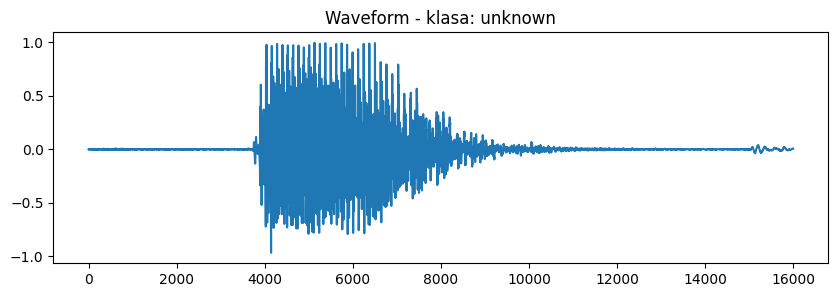

In [55]:
# Test usage of AudioDataset
dataset = AudioDataset(root_dir=os.path.join("..", "data", "train", "audio"), transform=None)

print("Liczba przykładów w dataset:", len(dataset))

waveform, label = dataset[2000]
print("Kształt waveforma:", waveform.shape)  # [1, no. of samples]
print("Etykieta (indeks):", label)
print("Etykieta (nazwisko):", dataset.idx2label[label])
from collections import Counter
label_counter = Counter()

for i in range(len(dataset)):
    _, label = dataset[i]
    label_name = dataset.idx2label[label]
    label_counter[label_name] += 1


print("\n Liczba przykładów dla każdej klasy:")
for label_name, count in sorted(label_counter.items()):
    print(f"{label_name}: {count}")
plt.figure(figsize=(10, 3))
plt.title(f"Waveform - klasa: {dataset.idx2label[label]}")
plt.plot(waveform.t().numpy())
plt.show()


# Spektogram

In [56]:
mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=16000, 
    n_mels=64
)
db_transform = torchaudio.transforms.AmplitudeToDB()

def to_mel_spectrogram(waveform):
    spec = mel_transform(waveform)
    spec_db = db_transform(spec)
    return spec_db


Kształt spektrogramu (Mel, dB): torch.Size([1, 64, 81])


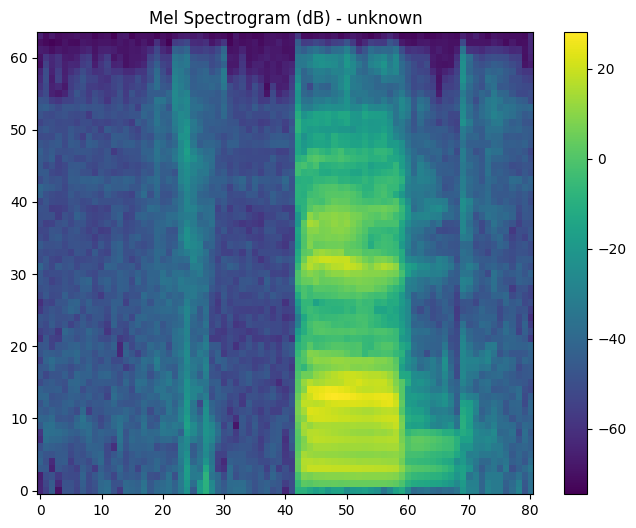

In [57]:
waveform, label = dataset[0]
waveform = waveform.float()  # conversion to float32
spec_db = to_mel_spectrogram(waveform)

print("Kształt spektrogramu (Mel, dB):", spec_db.shape)  # [1, n_mels, time]

plt.figure(figsize=(8, 6))
plt.title(f"Mel Spectrogram (dB) - {dataset.idx2label[label]}")
plt.imshow(spec_db.squeeze().numpy(), origin="lower", aspect="auto", cmap="viridis")
plt.colorbar()
plt.show()


# Zaladowanie danych treningowych

In [58]:
dataset_spec = AudioDataset(root_dir=os.path.join("..", "data", "train", "audio"), transform=to_mel_spectrogram)

# Checking of shape
x, y = dataset_spec[0]
print("Kształt X (spektrogramu):", x.shape)  # [1, n_mels, time]
print("Etykieta:", y, dataset_spec.idx2label[y])


Kształt X (spektrogramu): torch.Size([1, 64, 81])
Etykieta: 11 unknown


## Podział na zbiór treningowy i walidacyjny

In [59]:
train_size = int(0.8 * len(dataset_spec))
val_size = len(dataset_spec) - train_size

train_dataset, val_dataset = random_split(dataset_spec, [train_size, val_size])

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_collate_fn)

print("Liczba próbek w train_loader:", len(train_dataset))
print("Liczba próbek w val_loader:", len(val_dataset))


Liczba próbek w train_loader: 52274
Liczba próbek w val_loader: 13069


## Accuracy dla przypisania najliczniej reprezentowanej klasy

In [60]:
all_labels = [dataset_spec[i][1] for i in range(len(dataset_spec))]
most_common_label = max(set(all_labels), key=all_labels.count)
baseline_acc = all_labels.count(most_common_label) / len(all_labels) * 100

print(f"Najczęstsza klasa: {dataset_spec.idx2label[most_common_label]}")
print(f"Baseline accuracy (majority class): {baseline_acc:.2f}%")


Najczęstsza klasa: unknown
Baseline accuracy (majority class): 62.82%


# CNN

In [61]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        # Input: [batch, 1, n_mels, time]

        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.AdaptiveMaxPool2d((8, 8))  # -> [batch, 16, 8, 8]

        self.fc1 = nn.Linear(16 * 8 * 8, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        # x: [batch, 1, n_mels, time]
        x = F.relu(self.conv1(x))    # -> [batch, 8, n_mels, time]
        x = F.relu(self.conv2(x))    # -> [batch, 16, n_mels, time]
        x = self.pool(x)            # -> [batch, 16, 8, 8]
        x = x.view(x.size(0), -1)   # flattening to [batch, 16*8*8]
        x = F.relu(self.fc1(x))     # -> [batch, 64]
        x = self.fc2(x)             # -> [batch, num_classes]
        return x


In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Urządzenie:", device)

Urządzenie: cpu


## Trening CNN

In [63]:
num_classes = len(dataset_spec.label2idx)
model = SimpleCNN(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 2  

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(train_loader):
        # inputs: [batch_size, 1, n_mels, time]
        # labels: [batch_size]
        inputs = inputs.to(device)
        labels = labels.to(device)

        
        optimizer.zero_grad()

        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward + opt
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Average loss per epoch
    epoch_loss = running_loss / len(train_loader)
    print(f"[Epoch {epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f}")


[Epoch 1/2] Loss: 0.9881
[Epoch 2/2] Loss: 0.5656


# Walidacja

In [64]:
# Validation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs_val, labels_val in val_loader:
        inputs_val = inputs_val.to(device)
        labels_val = labels_val.to(device)

        outputs_val = model(inputs_val)
        _, predicted = torch.max(outputs_val, 1)
        total += labels_val.size(0)
        correct += (predicted == labels_val).sum().item()

val_acc = 100.0 * correct / total
print(f"Val Accuracy: {val_acc:.2f}%\n")

Val Accuracy: 82.81%



# Testy

0. Validation setup

In [65]:
def train_and_evaluate(model, train_loader, val_loader, optimizer, scheduler=None, num_epochs=2):
    model.to(device)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)

        # Validation phase
        model.eval()
        correct = 0
        total = 0
        val_loss = 0.0

        with torch.no_grad():
            for inputs_val, labels_val in val_loader:
                inputs_val = inputs_val.to(device)
                labels_val = labels_val.to(device)

                outputs_val = model(inputs_val)
                loss_val = criterion(outputs_val, labels_val)
                val_loss += loss_val.item()

                _, predicted = torch.max(outputs_val, 1)
                total += labels_val.size(0)
                correct += (predicted == labels_val).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100.0 * correct / total

        # Learning rate scheduling
        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(avg_val_loss)
            else:
                scheduler.step()

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    return val_acc

1. Learning Rate

In [66]:
model_lr1 = SimpleCNN(num_classes)
model_lr2 = SimpleCNN(num_classes)
model_lr3 = SimpleCNN(num_classes)

acc_lr1 = train_and_evaluate(model_lr1, train_loader, val_loader, optim.Adam(model_lr1.parameters(), lr=0.01))
acc_lr2 = train_and_evaluate(model_lr2, train_loader, val_loader, optim.Adam(model_lr2.parameters(), lr=0.001))
acc_lr3 = train_and_evaluate(model_lr3, train_loader, val_loader, optim.Adam(model_lr3.parameters(), lr=0.0001))

print(f"LR=0.01 Accuracy: {acc_lr1:.2f}%")
print(f"LR=0.001 Accuracy: {acc_lr2:.2f}%")
print(f"LR=0.0001 Accuracy: {acc_lr3:.2f}%")

Epoch 1/2 | Train Loss: 1.2690 | Val Loss: 1.1318 | Val Acc: 65.21%
Epoch 2/2 | Train Loss: 1.1337 | Val Loss: 1.1399 | Val Acc: 65.11%
Epoch 1/2 | Train Loss: 1.0427 | Val Loss: 0.7288 | Val Acc: 75.59%
Epoch 2/2 | Train Loss: 0.6422 | Val Loss: 0.5880 | Val Acc: 80.79%
Epoch 1/2 | Train Loss: 1.3357 | Val Loss: 1.1548 | Val Acc: 65.06%
Epoch 2/2 | Train Loss: 0.9900 | Val Loss: 0.8983 | Val Acc: 72.09%
LR=0.01 Accuracy: 65.11%
LR=0.001 Accuracy: 80.79%
LR=0.0001 Accuracy: 72.09%


2. Number of Layers and Neurons

In [ ]:
class DeeperCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, 1, 1)
        self.conv2 = nn.Conv2d(8, 16, 3, 1, 1)
        self.conv3 = nn.Conv2d(16, 32, 3, 1, 1)
        self.pool = nn.AdaptiveAvgPool2d((4, 4))
        self.fc = nn.Linear(32 * 4 * 4, num_classes)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

model_shallow = SimpleCNN(num_classes)
model_deep = DeeperCNN(num_classes)

acc_shallow = train_and_evaluate(model_shallow, train_loader, val_loader, optim.Adam(model_shallow.parameters(), lr=0.001))
acc_deep = train_and_evaluate(model_deep, train_loader, val_loader, optim.Adam(model_deep.parameters(), lr=0.001))

print(f"Shallow CNN Accuracy: {acc_shallow:.2f}%")
print(f"Deeper CNN Accuracy: {acc_deep:.2f}%")

Epoch 1/2 | Train Loss: 1.0367 | Val Loss: 0.7236 | Val Acc: 76.49%
Epoch 2/2 | Train Loss: 0.6026 | Val Loss: 0.5765 | Val Acc: 81.74%
Epoch 1/2 | Train Loss: 1.1313 | Val Loss: 0.7782 | Val Acc: 74.72%


3. Conv Layer Params (Stride and Filter Size)

In [ ]:
        model_stride1 = SimpleCNN(num_classes)
model_stride2 = SimpleCNN(num_classes)

model_stride1.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
model_stride2.conv1 = nn.Conv2d(1, 8, kernel_size=5, stride=2, padding=2)

acc_stride1 = train_and_evaluate(model_stride1, train_loader, val_loader, optim.Adam(model_stride1.parameters(), lr=0.001))
acc_stride2 = train_and_evaluate(model_stride2, train_loader, val_loader, optim.Adam(model_stride2.parameters(), lr=0.001))

print(f"Stride 1 (3x3) Accuracy: {acc_stride1:.2f}%")
print(f"Stride 2 (5x5) Accuracy: {acc_stride2:.2f}%")

OutOfMemoryError: CUDA out of memory. Tried to allocate 476.00 MiB. GPU 0 has a total capacity of 3.68 GiB of which 141.38 MiB is free. Including non-PyTorch memory, this process has 3.52 GiB memory in use. Of the allocated memory 2.87 GiB is allocated by PyTorch, and 553.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

4. Activation fuction (ReLU vs Sigmoid)

In [ ]:
def test_activation_function():
    relu_model = SimpleCNN(num_classes=10)
    sigmoid_model = SimpleCNN(num_classes=10)

    relu_model.conv1 = nn.Sequential(nn.Conv2d(1, 8, 3, 1, 1), nn.ReLU())
    sigmoid_model.conv1 = nn.Sequential(nn.Conv2d(1, 8, 3, 1, 1), nn.Sigmoid())

    dummy_input = torch.randn(2, 1, 64, 100)  # [batch, channels, n_mels, time]
    relu_out = relu_model(dummy_input)
    sigmoid_out = sigmoid_model(dummy_input)

    assert relu_out.shape == sigmoid_out.shape == (2, 10)

In [ ]:
model_relu = SimpleCNN(num_classes)
model_relu.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
model_relu.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)

model_sigmoid = SimpleCNN(num_classes)
model_sigmoid.conv1 = nn.Sequential(nn.Conv2d(1, 8, 3, 1, 1), nn.Sigmoid())
model_sigmoid.conv2 = nn.Sequential(nn.Conv2d(8, 16, 3, 1, 1), nn.Sigmoid())

acc_relu = train_and_evaluate(model_relu, train_loader, val_loader, optim.Adam(model_relu.parameters(), lr=0.001))
acc_sigmoid = train_and_evaluate(model_sigmoid, train_loader, val_loader, optim.Adam(model_sigmoid.parameters(), lr=0.001))

print(f"ReLU Accuracy: {acc_relu:.2f}%")
print(f"Sigmoid Accuracy: {acc_sigmoid:.2f}%")

Epoch 1/2 | Train Loss: 0.8932 | Val Loss: 0.6043 | Val Acc: 80.43%
Epoch 2/2 | Train Loss: 0.5078 | Val Loss: 0.4737 | Val Acc: 84.84%
Epoch 1/2 | Train Loss: 1.2490 | Val Loss: 1.0138 | Val Acc: 68.08%
Epoch 2/2 | Train Loss: 0.8685 | Val Loss: 0.7572 | Val Acc: 75.46%
ReLU Accuracy: 84.84%
Sigmoid Accuracy: 75.46%


5. Pooling

In [ ]:
def test_pooling_variants():
    input_tensor = torch.randn(4, 8, 32, 32)

    max_pool = nn.AdaptiveMaxPool2d((8, 8))(input_tensor)
    avg_pool = nn.AdaptiveAvgPool2d((8, 8))(input_tensor)
    global_pool = nn.AdaptiveMaxPool2d((1, 1))(input_tensor)

    assert max_pool.shape == avg_pool.shape == (4, 8, 8, 8)
    assert global_pool.shape == (4, 8, 1, 1)

In [ ]:
class CNN_MaxPool(SimpleCNN):
    def __init__(self, num_classes):
        super().__init__(num_classes)
        self.pool = nn.AdaptiveMaxPool2d((8, 8))

class CNN_AvgPool(SimpleCNN):
    def __init__(self, num_classes):
        super().__init__(num_classes)
        self.pool = nn.AdaptiveAvgPool2d((8, 8))

model_max = CNN_MaxPool(num_classes)
model_avg = CNN_AvgPool(num_classes)

acc_max = train_and_evaluate(model_max, train_loader, val_loader, optim.Adam(model_max.parameters(), lr=0.001))
acc_avg = train_and_evaluate(model_avg, train_loader, val_loader, optim.Adam(model_avg.parameters(), lr=0.001))

print(f"MaxPool Accuracy: {acc_max:.2f}%")
print(f"AvgPool Accuracy: {acc_avg:.2f}%")

Epoch 1/2 | Train Loss: 0.7925 | Val Loss: 0.5001 | Val Acc: 83.61%
Epoch 2/2 | Train Loss: 0.4387 | Val Loss: 0.4492 | Val Acc: 85.98%
Epoch 1/2 | Train Loss: 1.0038 | Val Loss: 0.6988 | Val Acc: 76.74%
Epoch 2/2 | Train Loss: 0.5644 | Val Loss: 0.4887 | Val Acc: 84.30%
MaxPool Accuracy: 85.98%
AvgPool Accuracy: 84.30%


6. Initialization

In [ ]:
def test_initialization_methods():
    conv = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
    torch.nn.init.kaiming_normal_(conv.weight, nonlinearity='relu')
    kaiming_std = conv.weight.std().item()

    conv = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
    torch.nn.init.xavier_normal_(conv.weight)
    xavier_std = conv.weight.std().item()

    assert kaiming_std != xavier_std 

In [ ]:
def apply_he(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')

def apply_xavier(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.xavier_uniform_(m.weight)

model_he = SimpleCNN(num_classes)
model_xavier = SimpleCNN(num_classes)

apply_he(model_he)
apply_xavier(model_xavier)

acc_he = train_and_evaluate(model_he, train_loader, val_loader, optim.Adam(model_he.parameters(), lr=0.001))
acc_xavier = train_and_evaluate(model_xavier, train_loader, val_loader, optim.Adam(model_xavier.parameters(), lr=0.001))

print(f"He Init Accuracy: {acc_he:.2f}%")
print(f"Xavier Init Accuracy: {acc_xavier:.2f}%")

Epoch 1/2 | Train Loss: 1.5924 | Val Loss: 1.2898 | Val Acc: 64.78%
Epoch 2/2 | Train Loss: 1.2698 | Val Loss: 1.2493 | Val Acc: 64.78%
Epoch 1/2 | Train Loss: 1.0605 | Val Loss: 0.7315 | Val Acc: 75.84%
Epoch 2/2 | Train Loss: 0.5920 | Val Loss: 0.5241 | Val Acc: 82.62%
He Init Accuracy: 64.78%
Xavier Init Accuracy: 82.62%


7. Optimizer: SGD vs Adam vs SGD+Momentum

In [ ]:
def test_optimizer_variants():
    model = SimpleCNN(num_classes=10)
    sgd = optim.SGD(model.parameters(), lr=0.01)
    adam = optim.Adam(model.parameters(), lr=0.01)
    momentum = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    assert isinstance(sgd, optim.Optimizer)
    assert isinstance(adam, optim.Optimizer)
    assert isinstance(momentum, optim.Optimizer)

In [ ]:
model_sgd = SimpleCNN(num_classes)
model_adam = SimpleCNN(num_classes)
model_momentum = SimpleCNN(num_classes)

opt_sgd = optim.SGD(model_sgd.parameters(), lr=0.01)
opt_adam = optim.Adam(model_adam.parameters(), lr=0.001)
opt_momentum = optim.SGD(model_momentum.parameters(), lr=0.01, momentum=0.9)

acc_sgd = train_and_evaluate(model_sgd, train_loader, val_loader, opt_sgd)
acc_adam = train_and_evaluate(model_adam, train_loader, val_loader, opt_adam)
acc_momentum = train_and_evaluate(model_momentum, train_loader, val_loader, opt_momentum)

print(f"SGD Accuracy: {acc_sgd:.2f}%")
print(f"Adam Accuracy: {acc_adam:.2f}%")
print(f"Momentum Accuracy: {acc_momentum:.2f}%")

Epoch 1/2 | Train Loss: 1.0162 | Val Loss: 0.6863 | Val Acc: 77.59%
Epoch 2/2 | Train Loss: 0.5541 | Val Loss: 0.4376 | Val Acc: 85.75%
Epoch 1/2 | Train Loss: 0.8652 | Val Loss: 0.5509 | Val Acc: 81.74%
Epoch 2/2 | Train Loss: 0.4788 | Val Loss: 0.4700 | Val Acc: 84.58%
Epoch 1/2 | Train Loss: 1.0182 | Val Loss: 0.8749 | Val Acc: 72.46%
Epoch 2/2 | Train Loss: 0.8240 | Val Loss: 0.8358 | Val Acc: 73.60%
SGD Accuracy: 85.75%
Adam Accuracy: 84.58%
Momentum Accuracy: 73.60%


8. Batch Size

In [ ]:
def test_batch_size_effect():
    from torch.utils.data import TensorDataset, DataLoader

    dummy_data = torch.randn(100, 1, 64, 50)
    dummy_labels = torch.randint(0, 10, (100,))
    dataset = TensorDataset(dummy_data, dummy_labels)

    loader_small = DataLoader(dataset, batch_size=8)
    loader_large = DataLoader(dataset, batch_size=32)

    assert len(list(loader_small)) > len(list(loader_large))

In [ ]:
# Needs more than 4 GB of GPU memory

model_bs8 = SimpleCNN(num_classes)
model_bs16 = SimpleCNN(num_classes)
model_bs32 = SimpleCNN(num_classes)

loader_bs8 = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=pad_collate_fn)
loader_bs16 = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=pad_collate_fn)
loader_bs32 = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=pad_collate_fn)

acc_bs8 = train_and_evaluate(model_bs8, loader_bs8, val_loader, optim.Adam(model_bs8.parameters(), lr=0.001))
acc_bs16 = train_and_evaluate(model_bs16, loader_bs16, val_loader, optim.Adam(model_bs16.parameters(), lr=0.001))
acc_bs32 = train_and_evaluate(model_bs32, loader_bs32, val_loader, optim.Adam(model_bs32.parameters(), lr=0.001))

print(f"Batch Size 8 Accuracy: {acc_bs8:.2f}%")
print(f"Batch Size 16 Accuracy: {acc_bs16:.2f}%")
print(f"Batch Size 32 Accuracy: {acc_bs32:.2f}%")

Epoch 1/2 | Train Loss: 0.8433 | Val Loss: 0.6108 | Val Acc: 79.93%
Epoch 2/2 | Train Loss: 0.5184 | Val Loss: 0.4720 | Val Acc: 84.56%
Epoch 1/2 | Train Loss: 0.8124 | Val Loss: 0.5175 | Val Acc: 83.00%
Epoch 2/2 | Train Loss: 0.4538 | Val Loss: 0.4192 | Val Acc: 86.96%
Epoch 1/2 | Train Loss: 0.9190 | Val Loss: 0.6060 | Val Acc: 80.60%
Epoch 2/2 | Train Loss: 0.5243 | Val Loss: 0.4956 | Val Acc: 84.13%
Batch Size 8 Accuracy: 84.56%
Batch Size 16 Accuracy: 86.96%
Batch Size 32 Accuracy: 84.13%


9. Learning Rate Schedule

In [ ]:
def test_lr_scheduler_step():
    model = SimpleCNN(num_classes=10)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

    lrs = []
    for _ in range(3):
        optimizer.step()
        scheduler.step()
        lrs.append(optimizer.param_groups[0]['lr'])

    assert lrs == [0.01, 0.001, 0.0001]

In [ ]:
model_nosched = SimpleCNN(num_classes)
model_step = SimpleCNN(num_classes)
model_plateau = SimpleCNN(num_classes)

opt_nosched = optim.Adam(model_nosched.parameters(), lr=0.001)
opt_step = optim.Adam(model_step.parameters(), lr=0.001)
opt_plateau = optim.Adam(model_plateau.parameters(), lr=0.001)

sched_step = optim.lr_scheduler.StepLR(opt_step, step_size=1, gamma=0.9)
sched_plateau = optim.lr_scheduler.ReduceLROnPlateau(opt_plateau, patience=1)

acc_nosched = train_and_evaluate(model_nosched, train_loader, val_loader, opt_nosched, scheduler=None)
acc_step = train_and_evaluate(model_step, train_loader, val_loader, opt_step, scheduler=sched_step)
acc_plateau = train_and_evaluate(model_plateau, train_loader, val_loader, opt_plateau, scheduler=sched_plateau)

print(f"No Scheduler Accuracy: {acc_nosched:.2f}%")
print(f"StepLR Accuracy: {acc_step:.2f}%")
print(f"ReduceLROnPlateau Accuracy: {acc_plateau:.2f}%")

Epoch 1/2 | Train Loss: 0.8234 | Val Loss: 0.5368 | Val Acc: 82.59%
Epoch 2/2 | Train Loss: 0.4619 | Val Loss: 0.4352 | Val Acc: 86.54%
Epoch 1/2 | Train Loss: 0.7995 | Val Loss: 0.5340 | Val Acc: 82.47%
Epoch 2/2 | Train Loss: 0.4455 | Val Loss: 0.4135 | Val Acc: 86.59%
Epoch 1/2 | Train Loss: 0.8060 | Val Loss: 0.5145 | Val Acc: 83.39%
Epoch 2/2 | Train Loss: 0.4383 | Val Loss: 0.4054 | Val Acc: 87.06%
No Scheduler Accuracy: 86.54%
StepLR Accuracy: 86.59%
ReduceLROnPlateau Accuracy: 87.06%


10. Batch Normalization: With vs Without

In [ ]:
class CNN_BatchNorm(SimpleCNN):
    def __init__(self, num_classes):
        super().__init__(num_classes)
        self.bn1 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(16)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

model_no_bn = SimpleCNN(num_classes)
model_bn = CNN_BatchNorm(num_classes)

acc_no_bn = train_and_evaluate(model_no_bn, train_loader, val_loader, optim.Adam(model_no_bn.parameters(), lr=0.001))
acc_bn = train_and_evaluate(model_bn, train_loader, val_loader, optim.Adam(model_bn.parameters(), lr=0.001))

print(f"No BatchNorm Accuracy: {acc_no_bn:.2f}%")
print(f"With BatchNorm Accuracy: {acc_bn:.2f}%")

11. Skip Connections (Residual Block)

In [ ]:
class CNN_Skip(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, 1, 1)
        self.conv2 = nn.Conv2d(8, 8, 3, 1, 1)
        self.pool = nn.AdaptiveAvgPool2d((4, 4))
        self.fc = nn.Linear(8 * 4 * 4, num_classes)

    def forward(self, x):
        residual = F.relu(self.conv1(x))
        out = F.relu(self.conv2(residual))
        out += residual  # skip connection
        out = self.pool(out)
        out = out.view(out.size(0), -1)
        return self.fc(out)

model_skip = CNN_Skip(num_classes)
model_noskip = SimpleCNN(num_classes)

acc_noskip = train_and_evaluate(model_noskip, train_loader, val_loader, optim.Adam(model_noskip.parameters(), lr=0.001))
acc_skip = train_and_evaluate(model_skip, train_loader, val_loader, optim.Adam(model_skip.parameters(), lr=0.001))

print(f"No Skip Accuracy: {acc_noskip:.2f}%")
print(f"Skip Connection Accuracy: {acc_skip:.2f}%")

12. Weight Decay

In [ ]:
model_wd0 = SimpleCNN(num_classes)
model_wd1 = SimpleCNN(num_classes)
model_wd2 = SimpleCNN(num_classes)

opt_wd0 = optim.Adam(model_wd0.parameters(), lr=0.001, weight_decay=0.0)
opt_wd1 = optim.Adam(model_wd1.parameters(), lr=0.001, weight_decay=0.001)
opt_wd2 = optim.Adam(model_wd2.parameters(), lr=0.001, weight_decay=0.01)

acc_wd0 = train_and_evaluate(model_wd0, train_loader, val_loader, opt_wd0)
acc_wd1 = train_and_evaluate(model_wd1, train_loader, val_loader, opt_wd1)
acc_wd2 = train_and_evaluate(model_wd2, train_loader, val_loader, opt_wd2)

print(f"No Weight Decay Accuracy: {acc_wd0:.2f}%")
print(f"Weight Decay 0.001 Accuracy: {acc_wd1:.2f}%")
print(f"Weight Decay 0.01 Accuracy: {acc_wd2:.2f}%")